omotuyoa@mail.uc.edu 

#**Classification of digits 0-9 based on audio signals using different machine learning techniques.**

## **Dataset Overview**
The Spoken digits dataset contains 1500 voice recordings of digits from 0 to 9.
Dataset Link: https://www.kaggle.com/divyanshu99/spoken-digit-dataset/tasks?taskId=3435. The dataset is balanced containing equal 150 samples for each digits. 3 speakers, 1500 recordings (50 of each digit per speaker). The features extracted are detailed in the` Feature Extraction Section`.

## **Problem Definition**
**Problem Statement:** The goal of this project is to *classify* each audio signals into the corresponding digits from 0-9 pronounced using Minimum Distance Classifier (MDC), K-Nearest Neighbours (KNN), Artificial Neural Network(ANN) and Convolutional Neural Network (CNN). ***The label is the digits from 0-9.*** For all the models, 60% of the data was used for `training` and 40% for `testing`.

**Input:** Audio Signals (.wav) or Melspectrogram Images (.png) for CNN

**Output:** Digits between 0 to 9.

**Metrics:** Precision, Accuracy, F1-Score and Recall were used to evaluate each model.

## **Problem Description**
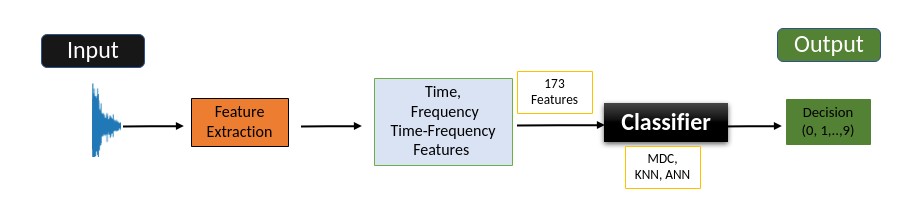
## **CNN Problem Description**
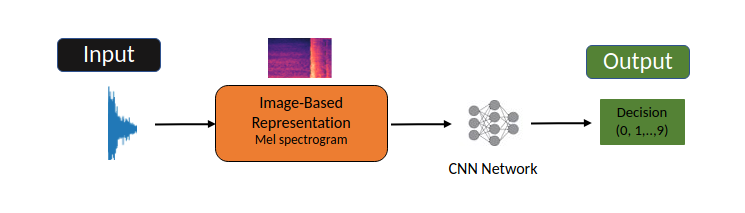

## **Processed Data and Files**
The processed data including features extracted, melspectrogram images and data can be downloaded from https://drive.google.com/drive/folders/1tUxKJoBSeqAT3th5eZa4nLBt5rRXc3hV?usp=sharing.


**Important Folders**

*   Features: /free-spoken-digit-dataset-master/features
*   Data Label: /free-spoken-digit-dataset-master/info
*   Melspectrogram Training Data: /free-spoken-digit-dataset-master/train_mel
*   Melspectrogram Test Data: /free-spoken-digit-dataset-master/test_mel






# Implementation

In [ ]:
import librosa
from librosa.effects import trim
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score
from sklearn.metrics import plot_confusion_matrix
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

from PIL import Image
import pathlib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
import csv
from tqdm import tqdm

import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime


# Loading Data

In [ ]:
dir = "drive/MyDrive/free-spoken-digit-dataset-master/recordings"
paths = os.listdir(dir)

X = []
y = []
for path in tqdm(paths):
    label = int(path.split("_")[0])
    data, sr = librosa.load(dir+ '/' + path)
    X.append(data.astype(np.float16))
    y.append(label)

100%|██████████| 1500/1500 [08:35<00:00,  2.91it/s]


In [ ]:
print(sr)

22050


# Visualize Audio Data


### Data Balanced check

The problem is balanced and there are 150 samples for each of the classes.

In [ ]:
np.unique(y, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([150, 150, 150, 150, 150, 150, 150, 150, 150, 150]))

In [ ]:
len(X[2]),  len(X[5]), len(X[8])

(5273, 6034, 4976)

### Visualizing Shortest and Longest Audio Signals

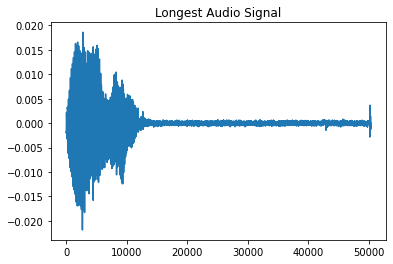

In [ ]:
#plotting wave for the shortest and longest audio
rate = 22050
audio_signal_lengths = [len(x) for x in X]
l_idx = np.argmax(audio_signal_lengths)
s_idx = np.argmin(audio_signal_lengths)

plt.plot(X[l_idx])
plt.title("Longest Audio Signal");
ipd.Audio(X[l_idx], rate=rate)


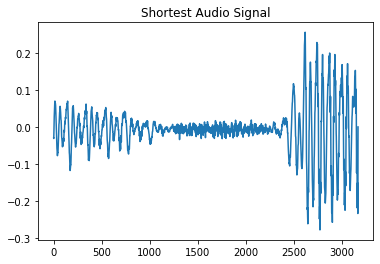

In [ ]:
plt.plot(X[s_idx])
plt.title("Shortest Audio Signal");
ipd.Audio(X[s_idx], rate=22050)

# Cleaning Data 
The audio signals have different length. Some have silence before and after the digits are pronounced. The cleaning technique I implemented here is to remove the silence by removing anything below 10db.

In [ ]:
# by default anything below 10 db is considered as silence
def remove_silence(sample, sr= 8000, top_db = 10):
    """This function removes trailing and leading silence periods of audio signals.
    """
    y = np.array(sample, dtype = np.float64)
    yt, _ = trim(y, top_db= top_db)
    return yt

In [ ]:
X_tr = [remove_silence(x) for x in X]

## Visualize Trimmed Audio Signals

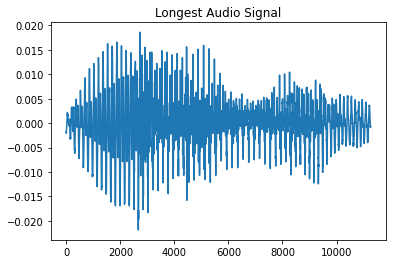

In [ ]:
#plotting wave for the trimmed longest audio
rate = 22050
plt.plot(X_tr[l_idx])
plt.title("Longest Audio Signal");
ipd.Audio(X_tr[l_idx], rate=rate)


# Feature extraction

In this section, I combined loading the data, cleaning the data and extracting the features from the clean data. The features are saved in a .csv, hence, this **block is ran ONLY once.**

## Time-Frequency Features
The mean of the five(5) audio feature array were extracted and implemented over the each audio signals. Each features is an array of features over the length of each audio signals. The features are length of array is described below:



*   **Mel Frequency Cepstral Coefficients (MFCCs)** - 20
*   **Chroma** - 12
*   **Mean of Mel spectrogram (Mel)** - 128
*   **Spectral Contrast** - 7
*   **Tonnetz** - 6

**Total: 173 features**

*   Mel Frequency Cepstral Coefficients (MFCCs) — Coefficients that make up the spectral representation of sound based on frequency bands spaced according to the human auditory system’s response (Mel scale). 
*    Chroma — A chroma feature or vector is typically a 12-element feature vector indicating how much energy of each pitch class, {C, C#, D, D#, E, …, B}, is present in the signal.
*    Mean of Mel spectrogram (Mel) — Spectogram based on Mel scale.
*    Spectral Contrast — Indicates the center of mass of the spectrum.
*    Tonnetz — Represents tonal space.

In [ ]:
def extract_features_and_label(dir = ''):     
    labels = []
    filenames = []
    start = 0
    for f in tqdm(os.listdir(dir+ '/recordings/')):
        if f.endswith('.wav'):
            #audio features
            data, sr = librosa.load(dir+ '/recordings/' + f)

            #remove silence from data
            data = remove_silence(data)

            #normalizing the signals
            data = librosa.util.normalize(data)
            #extracting features
            mfccs = np.mean(librosa.feature.mfcc(y = data, sr=sr).T, axis = 0)
            spectral_centroids = librosa.feature.spectral_centroid(data+0.01, sr=sr)[0]
            stft = np.abs(librosa.stft(data))
            chroma = np.mean(librosa.feature.chroma_stft(S = stft, sr = sr).T, axis = 0)
            mel = np.mean(librosa.feature.melspectrogram(data, sr).T, axis = 0)
            contrast = np.mean(librosa.feature.spectral_contrast(S = stft, sr = sr).T, axis = 0)
            tonnetz = np.mean(librosa.feature.tonnetz(y = librosa.effects.harmonic(data), sr = sr).T, axis = 0)

            #labels and file_names
            label = f.split('_')[0]
            filenames.append(dir + "/recordings/" + f)
            labels.append([label, dir + "/" + f, data])

            #Extracting Melspectogram Images and saving it
            fig = plt.figure(figsize=[1,1])
            ax = fig.add_subplot(111)
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
            ax.set_frame_on(False)
            
            S = librosa.feature.melspectrogram(y=data, sr=sr)
            librosa.display.specshow(librosa.power_to_db(S, ref=np.max), x_axis='time', y_axis='mel')
            file  = dir+ '/'+ 'melspec/' + str(f[:-4]) + '.jpg'
            plt.savefig(file, dpi=500, bbox_inches='tight',pad_inches=0)
            plt.close()

            #saving to csv
            feature_names = ['mfccs', 'spectral_centroids', 'chroma', 'mel', 'contrast', 'tonnetz']
            features = [mfccs, spectral_centroids, chroma, mel, contrast,tonnetz]
            if start == 0:
              !rm $dir/features/*.csv
              !rm $dir/info/data.csv
              csvfile_data = open(dir+"/info/"+"data.csv", "a") 
              csvwriter_data = csv.writer(csvfile_data)
              csvwriter_data.writerow(np.concatenate((['label'], ["filenames"])))
              for i in range(len(feature_names)):
                csvfile = open(dir+"/"+'features/'+feature_names[i]+".csv", "a")
                csvwriter = csv.writer(csvfile)
                csvwriter.writerow([i for i in range(1, len(features[i])+1)])
              start = start+1

            for i in range(len(feature_names)):
              csvfile = open(dir+"/"+'features/'+feature_names[i]+".csv", "a")
              csvwriter = csv.writer(csvfile)
              csvwriter.writerow(features[i].astype('float32'))
            
          
            csvwriter_data.writerow([label, dir + "/recordings/" + f])


In [ ]:
master_dir = "drive/MyDrive/free-spoken-digit-dataset-master"
#extract_features_and_label(master_dir)

# Features and Labels

In this section, I loaded the features and labels that was saved in the previous section in the individual features .csv and data.csv respectively. 

I created 5 sets of features. Each set contains different numbers of feature arrays ranging from 1-5. This is to test each model with smaller set of feature sets and then gradually increase the features.

## Loading Features and Labels

In [ ]:
#reading features
master_dir = "drive/MyDrive/free-spoken-digit-dataset-master/"
mfccs = pd.read_csv(master_dir+'/'+'features/'+'mfccs.csv')
chroma = pd.read_csv(master_dir+'/'+'features/'+'chroma.csv')
mel = pd.read_csv(master_dir+'/'+'features/'+'mel.csv')
contrast = pd.read_csv(master_dir+'/'+'features/'+'contrast.csv')
tonnetz = pd.read_csv(master_dir+'/'+'features/'+'tonnetz.csv')

data = pd.read_csv(master_dir+"/info/"+"data.csv")
labels = data['label']

#concatenating the features
# 5 features
features = [mfccs, chroma, mel, contrast, tonnetz]
final_features = pd.concat(features,axis=1)



## Creating Feature Sets - Variating the number of features set from 1 - 5 features

In [ ]:
#Total number of unique features - notes each feature is not a single value but an array
print(len(mfccs.columns), len(chroma.columns), len(mel.columns), len(contrast.columns), len(tonnetz.columns))

20 12 128 7 6


In [ ]:
variable_features = []
temp = []
for i in range(len(features)):
  temp.append(features[i])
  variable_features.append(pd.concat(temp,axis=1))

print(len(variable_features[0].columns), len(variable_features[1].columns), len(variable_features[2].columns), len(variable_features[3].columns), len(variable_features[4].columns))

20 32 160 167 173


#Normalize Data

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

data_scaled = []
for i in range(5):
  scaler.fit(variable_features[i])
  data_scaled.append(scaler.transform(variable_features[i]))

In [ ]:
print(len(data_scaled[0][0]), len(data_scaled[1][0]), len(data_scaled[2][0]), len(data_scaled[3][0]), len(data_scaled[4][0]))

20 32 160 167 173


# Visualize Data

In [ ]:
#Digit 6
label = data['label'][0]
audio_sample = data['filenames'][0]
sig, sr = librosa.load(audio_sample)
sig=remove_silence(sig)
sig= librosa.util.normalize(sig)

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1,6,figsize=(20,5))
ax1.plot(sig)
ax1.title.set_text("Audio Signal: " + str(label));

ax2.plot(range(len(mfccs.iloc[1].to_numpy())),mfccs.iloc[1].to_numpy())
ax2.title.set_text("MFCCs for digit: " + str(label));

ax3.plot(range(len(chroma.iloc[1].to_numpy())),chroma.iloc[1].to_numpy(), color='r')
ax3.title.set_text("Chroma for digit: " + str(label));

ax4.plot(range(len(mel.iloc[1].to_numpy())),mel.iloc[1].to_numpy(), color='r')
ax4.title.set_text("Mel for digit: " + str(label));

ax5.plot(range(len(contrast.iloc[1].to_numpy())),contrast.iloc[1].to_numpy(), color='b')
ax5.title.set_text("Contrast for digit: " + str(label));

ax6.plot(range(len(tonnetz.iloc[1].to_numpy())),tonnetz.iloc[1].to_numpy(), color='b')
ax6.title.set_text("Tonnetz for digit: " + str(label));

#same for digit: 4
label = data['label'][5]
audio_sample = data['filenames'][5]
sig, sr = librosa.load(audio_sample)
sig=remove_silence(sig)
sig= librosa.util.normalize(sig)
ipd.Audio(sig, rate=sr)
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1,6,figsize=(20,5))
ax1.plot(sig)
ax1.title.set_text("Audio Signal: " + str(label));

#plot
# frames = range(len(spectral_centroids))
ax2.plot(range(len(mfccs.iloc[5].to_numpy())),mfccs.iloc[5].to_numpy())
ax2.title.set_text("MFCCs for digit: " + str(label));

ax3.plot(range(len(chroma.iloc[5].to_numpy())),chroma.iloc[5].to_numpy(), color='r')
ax3.title.set_text("Chroma for digit: " + str(label));

ax4.plot(range(len(mel.iloc[5].to_numpy())),mel.iloc[5].to_numpy(), color='r')
ax4.title.set_text("Mel for digit: " + str(label));

ax5.plot(range(len(contrast.iloc[5].to_numpy())),contrast.iloc[5].to_numpy(), color='b')
ax5.title.set_text("Contrast for digit: " + str(label));

ax6.plot(range(len(tonnetz.iloc[5].to_numpy())),tonnetz.iloc[5].to_numpy(), color='b')
ax6.title.set_text("Tonnetz for digit: " + str(label));



NameError: ignored

In [ ]:
len(data_scaled[0])

1500

#Split Data

In [ ]:
from sklearn.model_selection import train_test_split
X_training, X_testing, Y_training, Y_testing = [],[],[],[]
for i in range(5):
  X_tr, X_t, Y_tr, Y_t = train_test_split(data_scaled[i], labels, test_size=0.4, random_state=42)
  X_training.append(X_tr)
  X_testing.append(X_t)
  Y_training.append(Y_tr)
  Y_testing.append(Y_t)


In [ ]:
print(len(X_training[0][0]), len(X_training[1][0]), len(X_training[2][0]), len(X_training[3][0]), len(X_training[4][0]))
print("Training samples: ", len(X_training[0]), len(X_training[1]), len(X_training[2]), len(X_training[3]), len(X_training[4]))

20 32 160 167 173
Training samples:  900 900 900 900 900


# MDC Classifier


In [ ]:
from sklearn.neighbors import NearestCentroid

### Training

In [ ]:
mdc_F1_Score = ["F1-Score"]
mdc_Recall = ["Recall"]
mdc_Precision = ["Precision"]
mdc_Accuracy= ["Accuracy"]
mdc_train_time = ["Training time (secs)"]
mdc_test_time = ["Test time (secs)"]


for i in range(5):
  d1 = datetime.now()
  model = NearestCentroid()
  model.fit(X_training[i],Y_training[i])
  d2 = datetime.now()
  Y_testing_predicted=model.predict(X_testing[i])
  d3 = datetime.now()

  mdc_F1_Score.append(np.round(f1_score(Y_testing[i],Y_testing_predicted,average='weighted'),3))
  mdc_Recall.append(np.round(recall_score(Y_testing[i],Y_testing_predicted,average='weighted'),3))
  mdc_Precision.append(np.round(precision_score(Y_testing[i],Y_testing_predicted,average='weighted'),3))
  mdc_Accuracy.append(np.round(accuracy_score(Y_testing[i],Y_testing_predicted),3))
  mdc_train_time.append(np.round((d2 - d1).total_seconds() ,3))
  mdc_test_time.append(np.round((d3 - d2).total_seconds() ,3))


### Table of metrics for each feature sets


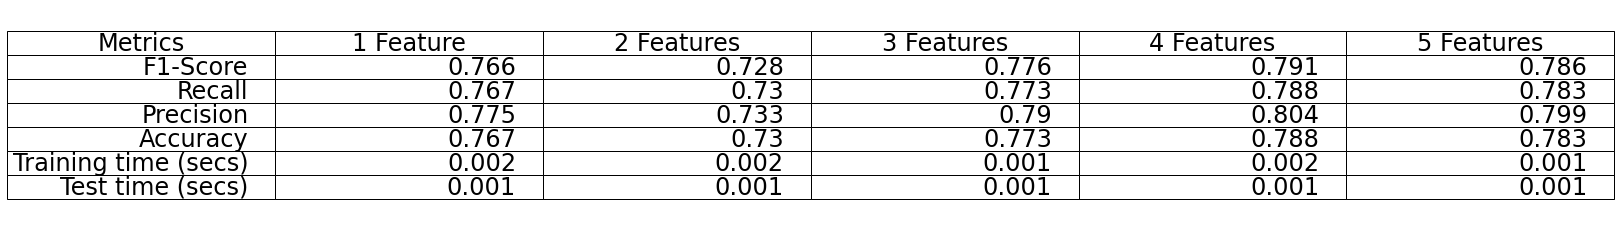

In [ ]:
metrics_mdc = [mdc_F1_Score, mdc_Recall, mdc_Precision, mdc_Accuracy, mdc_train_time, mdc_test_time]
fig = plt.figure()
ax = fig.add_subplot(111)
column_labels=["Metrics","1 Feature", "2 Features", "3 Features", "4 Features", "5 Features"]
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=metrics_mdc, colWidths=[.4] * 6,colLabels=column_labels,loc="center")
the_table.auto_set_font_size(False)
the_table.set_fontsize(24)
the_table.scale(2, 2)
plt.show()

# KNN Algorithm

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score

In [ ]:
F1_Score = np.zeros((5,15)) 
Recall = np.zeros((5,15)) 
Precision = np.zeros((5,15)) 
Accuracy= np.zeros((5,15)) 
K = np.zeros(15) 

In [ ]:
#run different K for each of the different lengths of features
for k in range(len(K)):
  K[k] = k+1
  model = KNeighborsClassifier(n_neighbors=k+1,p=1)
  for i in range(5):
    model.fit(X_training[i],Y_training[i])
    Y_testing_predicted=model.predict(X_testing[i])
    F1_Score[i,k] = f1_score(Y_testing[i],Y_testing_predicted,average='weighted')
    Recall[i,k] = recall_score(Y_testing[i],Y_testing_predicted,average='weighted')
    Precision[i,k] = precision_score(Y_testing[i],Y_testing_predicted,average='weighted')
    Accuracy[i,k] = accuracy_score(Y_testing[i],Y_testing_predicted)

## Graph of Evaluation Metrics Vs K-value

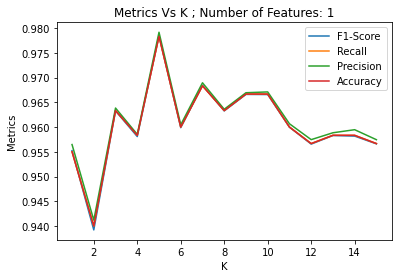

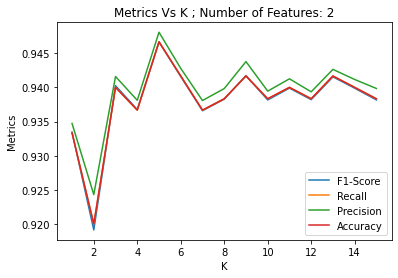

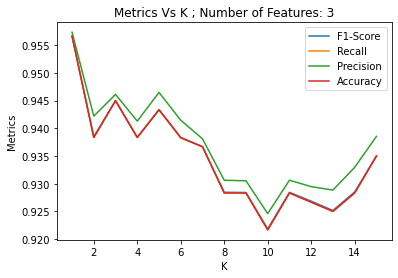

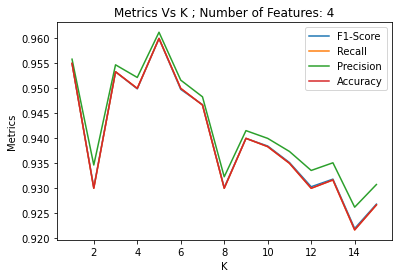

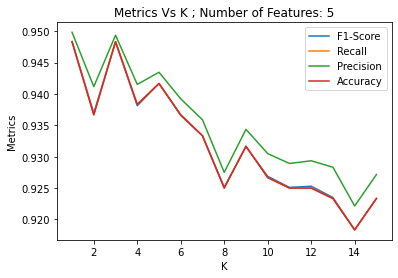

In [ ]:
for i in range(5):
  plt.figure()
  plt.plot(K, F1_Score[i], label="F1-Score")
  plt.plot(K, Recall[i], label="Recall")
  plt.plot(K, Precision[i], label="Precision")
  plt.plot(K, Accuracy[i], label="Accuracy")
  plt.xlabel("K")
  plt.ylabel("Metrics")
  plt.title('Metrics Vs K ; Number of Features: ' + str(i+1))
  plt.legend()

## Finding the best K based on the metrics

The best k was chosen where the value of the metrics where K is maximum. The value is the same for all the data.

In [ ]:
best_k_p = []
best_k_a = []
best_k_f1 = []
best_k_r = []

for i in range(5):
  best_k_p.append(np.argmax(Precision[i]))
  best_k_f1.append(np.argmax(F1_Score[i]))
  best_k_r.append(np.argmax(Recall[i]))
  best_k_a.append(np.argmax(Accuracy[i]))

print(best_k_p, best_k_f1, best_k_r, best_k_a)
best_k = [5, 5, 1, 5, 1]

[4, 4, 0, 4, 0] [4, 4, 0, 4, 0] [4, 4, 0, 4, 0] [4, 4, 0, 4, 0]


## KNN Classification with the best K for each features selection

### Training

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score


In [ ]:
knn_F1_Score = ["F1-Score"]
knn_Recall = ["Recall"]
knn_Precision = ["Precision"]
knn_Accuracy= ["Accuracy"]
knn_train_time = ["Training time (secs)"]
knn_test_time = ["Test time (secs)"]


for i in range(5):
  d1 = datetime.now()
  model = KNeighborsClassifier(n_neighbors=best_k[i],p=1)#Manhattan distance
  model.fit(X_training[i],Y_training[i])
  d2 = datetime.now()
  Y_testing_predicted=model.predict(X_testing[i])
  d3 = datetime.now()

  knn_F1_Score.append(np.round(f1_score(Y_testing[i],Y_testing_predicted,average='weighted'),3))
  knn_Recall.append(np.round(recall_score(Y_testing[i],Y_testing_predicted,average='weighted'),3))
  knn_Precision.append(np.round(precision_score(Y_testing[i],Y_testing_predicted,average='weighted'),3))
  knn_Accuracy.append(np.round(accuracy_score(Y_testing[i],Y_testing_predicted),3))
  knn_train_time.append(np.round((d2 - d1).total_seconds() ,4))
  knn_test_time.append(np.round((d3 - d2).total_seconds() ,3))



NameError: ignored

### Evaluation - Table of Metrics for each features set

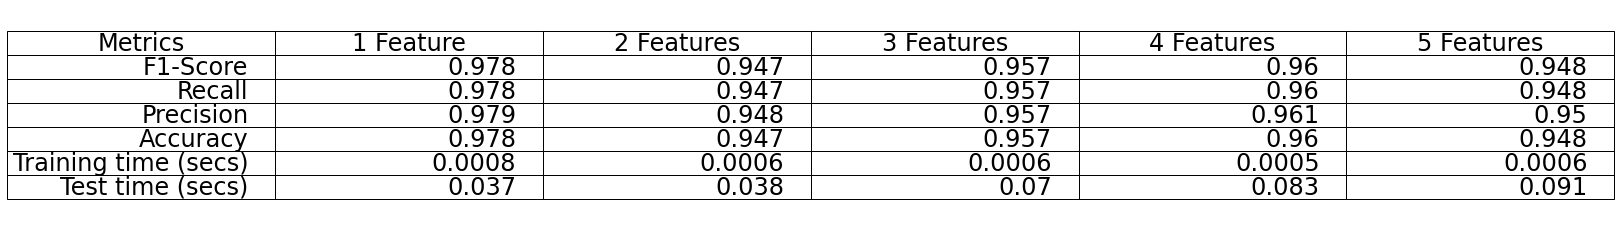

In [ ]:
metrics_knn = [knn_F1_Score, knn_Recall,knn_Precision, knn_Accuracy, knn_train_time, knn_test_time]
fig = plt.figure()
ax = fig.add_subplot(111)
column_labels=["Metrics","1 Feature", "2 Features", "3 Features", "4 Features", "5 Features"]
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=metrics_knn, colWidths=[.4] * 6,colLabels=column_labels,loc="center")
the_table.auto_set_font_size(False)
the_table.set_fontsize(24)
the_table.scale(2, 2)
plt.show()

# Multi-Layer Perceptron - Artificial Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier

## Training

In [ ]:
ann_F1_Score = ["F1-Score"]
ann_Recall = ["Recall"]
ann_Precision = ["Precision"]
ann_Accuracy= ["Accuracy"]
ann_train_time = ["Training time (secs)"]
ann_test_time = ["Test time (secs)"]


for i in range(5):
  d1 = datetime.now()
  MLP = MLPClassifier(activation='relu',solver='adam',hidden_layer_sizes=(150,100,50),max_iter=5000,random_state=1)
  MLP.fit(X_training[i], Y_training[i])
  d2 = datetime.now()
  MLP_Predicted=MLP.predict(X_testing[i])
  d3 = datetime.now()

  ann_F1_Score.append(np.round(f1_score(Y_testing[i],MLP_Predicted,average='weighted'),3))
  ann_Recall.append(np.round(recall_score(Y_testing[i],MLP_Predicted,average='weighted'),3))
  ann_Precision.append(np.round(precision_score(Y_testing[i],MLP_Predicted,average='weighted'),3))
  ann_Accuracy.append(np.round(accuracy_score(Y_testing[i],MLP_Predicted),3))
  ann_train_time.append(np.round((d2 - d1).total_seconds() ,3))
  ann_test_time.append(np.round((d3 - d2).total_seconds() ,3))
  

## Evaluation - Table of Metrics for each features set

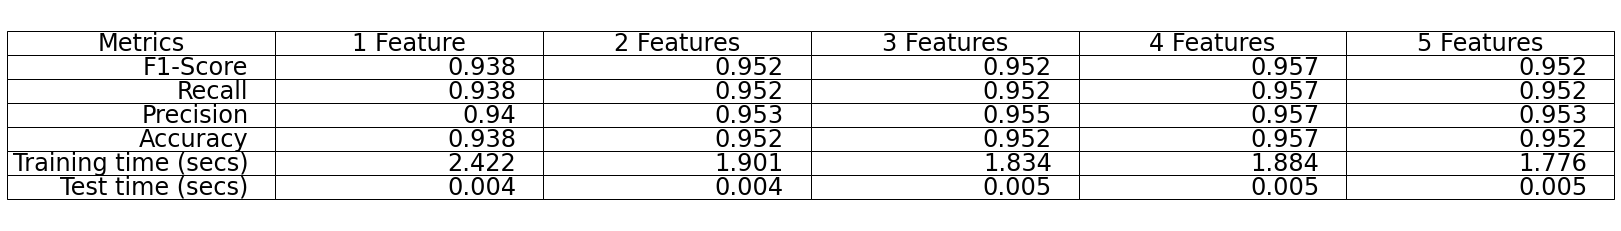

In [ ]:
metrics_ann = [ann_F1_Score, ann_Recall,ann_Precision, ann_Accuracy, ann_train_time, ann_test_time]
fig = plt.figure()
ax = fig.add_subplot(111)
column_labels=["Metrics","1 Feature", "2 Features", "3 Features", "4 Features", "5 Features"]
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=metrics_ann, colWidths=[.4] * 6,colLabels=column_labels,loc="center")
the_table.auto_set_font_size(False)
the_table.set_fontsize(24)
the_table.scale(2, 2)
plt.show()


# Convolutional Neural Network (CNN)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.preprocessing import image
from tensorflow.keras.models import load_model
import keras.backend as K

## Visualize Data

In [ ]:
mel_dir = master_dir + 'melspec/'
mel_paths = os.listdir(mel_dir)

full_path = []
labels_cnn = []
for path in mel_paths:
    label = int(path.split("_")[0])
    # data, sr = librosa.load(dir+ '/' + path)
    # X.append(data.astype(np.float16))
    full_path.append(mel_dir + path)
    labels_cnn.append(label)

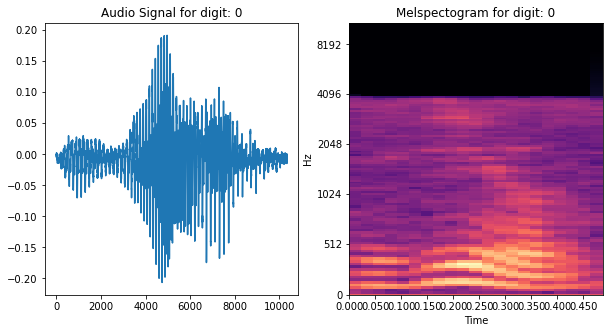

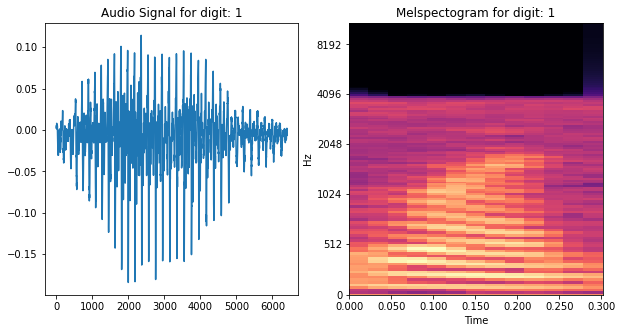

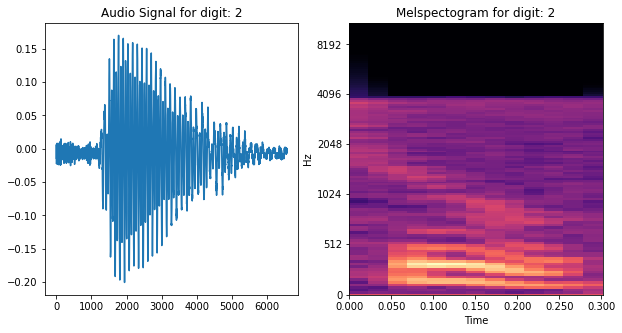

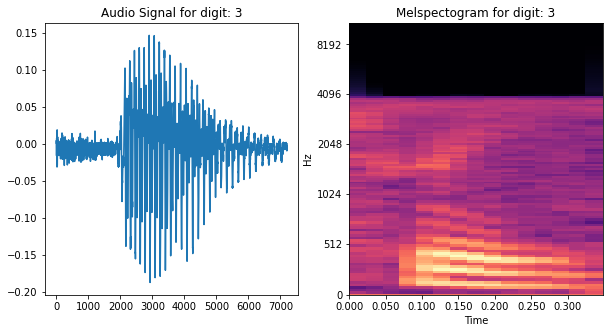

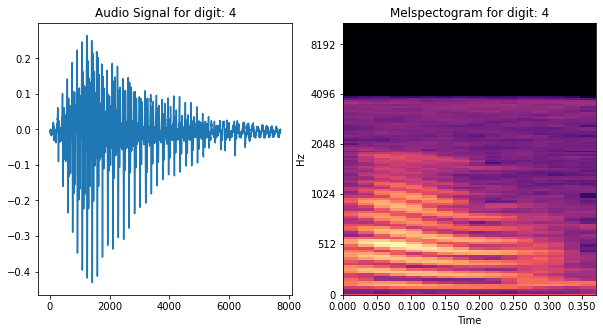

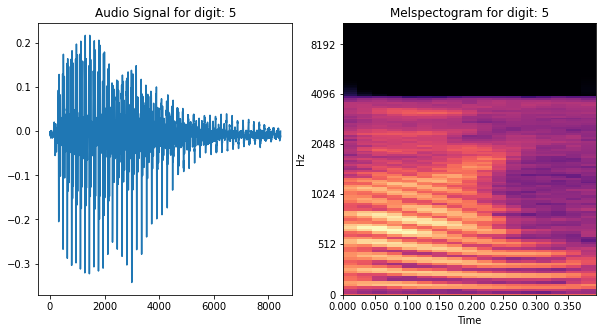

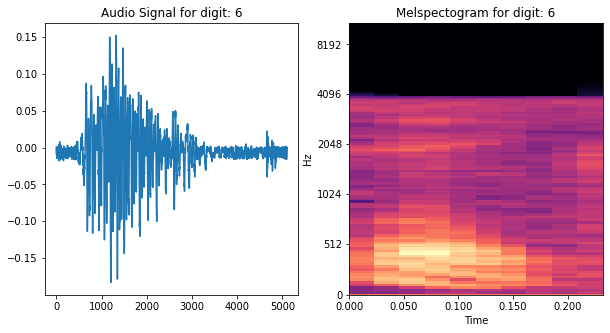

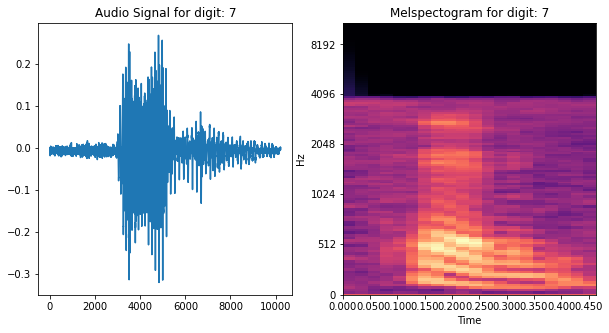

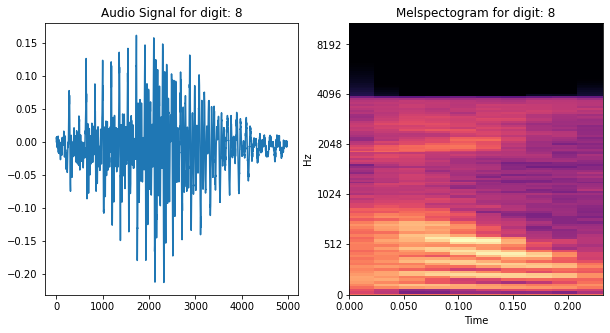

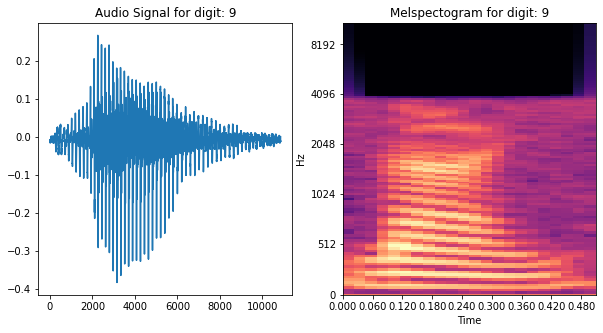

In [ ]:
for i in range(10):
    audio_sample= master_dir+'recordings/' + str(i)+'_nicolas_1.wav'
    signal, sr = librosa.load(audio_sample)
    ipd.Audio(signal, rate=sr)
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
    ax1.plot(signal)
    S = librosa.feature.melspectrogram(y=signal, sr=sr)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max), x_axis='time', y_axis='mel')
    ax1.title.set_text("Audio Signal for digit: " + str(i))
    ax2.title.set_text("Melspectogram for digit: " + str(i))

## Split Data into folders


In [ ]:
from sklearn.model_selection import train_test_split
X_training_file, X_testing_file, Y_training_file, Y_testing_file = train_test_split(full_path, labels_cnn, test_size=0.4, random_state=42)


In [ ]:
X_training_file[1]

'drive/MyDrive/free-spoken-digit-dataset-master/melspec/6_jackson_15.jpg'

In [ ]:
import shutil, os
train_dest = '/gdrive/MyDrive/free-spoken-digit-dataset-master/train_mel'
test_dest = '/gdrive/MyDrive/free-spoken-digit-dataset-master/test_mel'


In [ ]:
# #make directories:
# directories = ['0','1','2','3','4','5','6','7','8','9']
# for i in range(10):
#   path_train = os.path.join(train_dest, directories[i])
#   os.mkdir(path_train)
#   path_test= os.path.join(test_dest, directories[i])
#   os.mkdir(path_test)

In [ ]:
def create_categories(files, dest):
  for path in files:
    file_name = path.split('/')[-1]
    label = str(file_name.split("_")[0])
    f_dest = os.path.join(dest, label)
    shutil.copy(path, f_dest)


In [ ]:
# create_categories(X_training_file, train_dest)
# create_categories(X_testing_file, test_dest)


In [ ]:
dest_p = []
dest_p_t = []
for i in range(10):
  dest_paths_t = os.listdir( os.path.join(train_dest, str(i)))
  dest_p_t.append(len(dest_paths_t))
  dest_paths = os.listdir( os.path.join(test_dest, str(i)))
  dest_p.append(len(dest_paths))
print("Training samples", sum(dest_p_t))
print("Test samples",sum(dest_p))

Training samples 900
Test samples 600


In [ ]:
# create_categories(X_testing_file, test_dest)

## Data Generator and Normalization

In [ ]:
datagen = ImageDataGenerator(
                    rescale=1./255)
train_generator = datagen.flow_from_directory(
    train_dest,
    target_size=(377, 387),
    color_mode="rgb",
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)

NameError: ignored

## Build CNN Model

In [ ]:
def f1_score_(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
model=tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64,(3,3),input_shape=[377, 387, 3],activation="relu"),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(32,(3,3),activation="relu"),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(16,(3,3),activation="relu"),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64,activation="relu"),
        tf.keras.layers.Dense(10,activation="softmax"),])

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(377, 387, 3)))
model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))


## Train CNN Model

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), f1_score_])
d1 = datetime.now()
history = model.fit(train_generator, batch_size=64,epochs=20)
d2 = datetime.now()
train_time = (d2-d1).total_seconds()


Epoch 1/20
29/29 [==============================] - 12s 372ms/step - loss: 2.3577 - accuracy: 0.1678 - precision_11: 0.0938 - recall_11: 0.0033 - f1_score_: 0.0032
Epoch 2/20
29/29 [==============================] - 11s 372ms/step - loss: 1.6117 - accuracy: 0.4333 - precision_11: 0.7989 - recall_11: 0.1589 - f1_score_: 0.2153
Epoch 3/20
29/29 [==============================] - 11s 372ms/step - loss: 0.5776 - accuracy: 0.8111 - precision_11: 0.8826 - recall_11: 0.7267 - f1_score_: 0.7891
Epoch 4/20
29/29 [==============================] - 11s 373ms/step - loss: 0.2844 - accuracy: 0.9078 - precision_11: 0.9255 - recall_11: 0.8978 - f1_score_: 0.9139
Epoch 5/20
29/29 [==============================] - 11s 374ms/step - loss: 0.2260 - accuracy: 0.9356 - precision_11: 0.9512 - recall_11: 0.9311 - f1_score_: 0.9426
Epoch 6/20
29/29 [==============================] - 11s 372ms/step - loss: 0.0964 - accuracy: 0.9678 - precision_11: 0.9730 - recall_11: 0.9622 - f1_score_: 0.9685
Epoch 7/20
29/29

## Save Model

In [ ]:
model.save(master_dir+'/my_model/cnn4_model')

NameError: ignored

## Loading Model

In [ ]:
from tensorflow import keras
new_model = tf.keras.models.load_model('/gdrive/MyDrive/free-spoken-digit-dataset-master/my_model/cnn4_model', custom_objects={'f1_score_':f1_score_})

## Test CNN Model

In [ ]:
test_generator = datagen.flow_from_directory(
    test_dest,
    target_size=(377, 387),
    color_mode="rgb",
    class_mode=None,
    shuffle=False
)
d1 = datetime.now()

cnn_pred = new_model.predict_generator(test_generator, 600 // 32+1)
d2 = datetime.now()
test_time = (d2-d1).total_seconds()

cnn_pred = np.argmax(cnn_pred, axis=1)

Found 600 images belonging to 10 classes.


Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        72
           1       1.00      1.00      1.00        59
           2       0.97      0.98      0.97        57
           3       1.00      0.97      0.98        58
           4       0.98      1.00      0.99        51
           5       0.97      1.00      0.99        66
           6       0.98      0.98      0.98        55
           7       1.00      1.00      1.00        60
           8       0.98      0.95      0.97        61
           9       1.00      0.98      0.99        61

    accuracy                           0.98       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.98      0.98       600



NameError: ignored

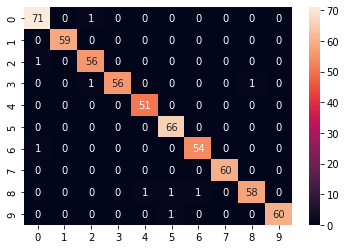

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
directories = ['0','1','2','3','4','5','6','7','8','9']

print('Classification Report')
print(classification_report(test_generator.classes, cnn_pred, target_names=directories))
cm = confusion_matrix(test_generator.classes, cnn_pred)

f = sns.heatmap(cm, annot=True, fmt='d')


cnn_F1_Score = ["F1-Score"]
cnn_Recall = ["Recall"]
cnn_Precision = ["Precision"]
cnn_Accuracy= ["Accuracy"]
cnn_train_time= ["Train Time (secs)"]
cnn_test_time= ["Test Time (secs)"]

cnn_F1_Score.append(np.round(f1_score(test_generator.classes,cnn_pred,average='weighted'),3))
cnn_Recall.append(np.round(recall_score(test_generator.classes,cnn_pred,average='weighted'),3))
cnn_Precision.append(np.round(precision_score(test_generator.classes,cnn_pred,average='weighted'),3))
cnn_Accuracy.append(np.round(accuracy_score(test_generator.classes,cnn_pred),3))
cnn_train_time.append(train_time)
cnn_test_time.append(test_time)

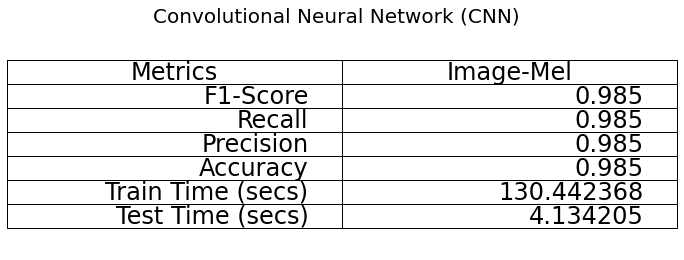

In [ ]:
metrics_cnn= [cnn_F1_Score, cnn_Recall, cnn_Precision, cnn_Accuracy, cnn_train_time, cnn_test_time]
fig = plt.figure()
ax = fig.add_subplot(111)
column_labels=["Metrics","Image-Mel"]
ax.axis('tight')
ax.axis('off')
fig.suptitle('Convolutional Neural Network (CNN)', fontsize=20)
the_table = ax.table(cellText=metrics_cnn, colWidths=[.5] * 2,colLabels=column_labels,loc="center")
the_table.auto_set_font_size(False)
the_table.set_fontsize(24)
the_table.scale(2, 2)
plt.show()

# Comparision of all the models - MDC, KNN, ANN and CNN  

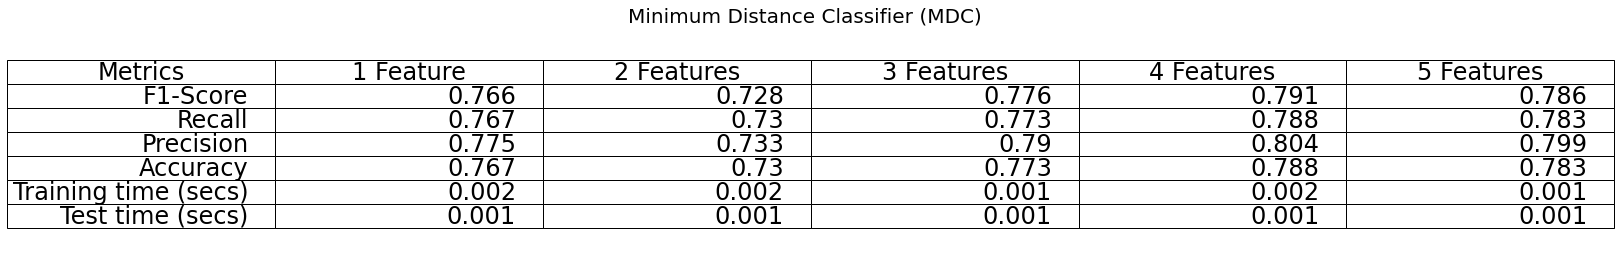

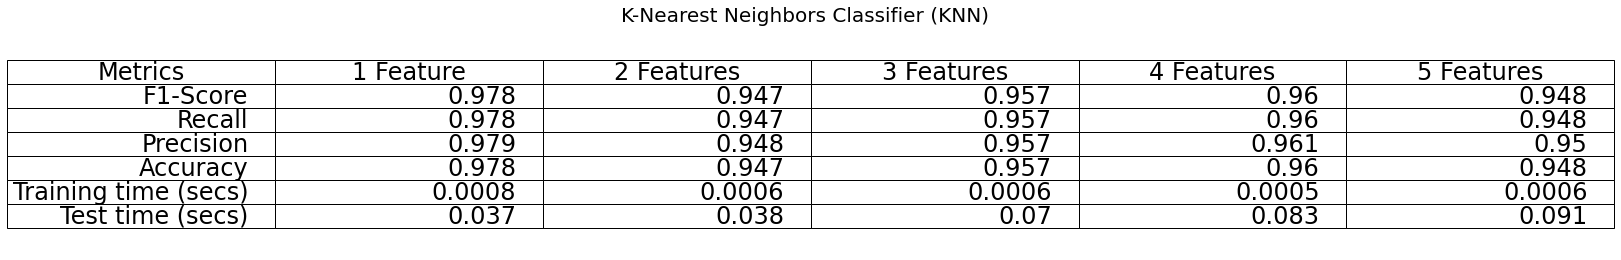

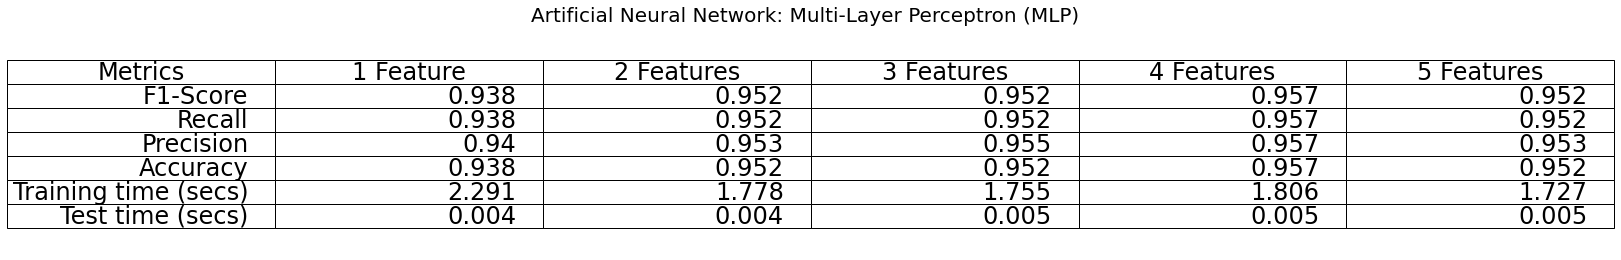

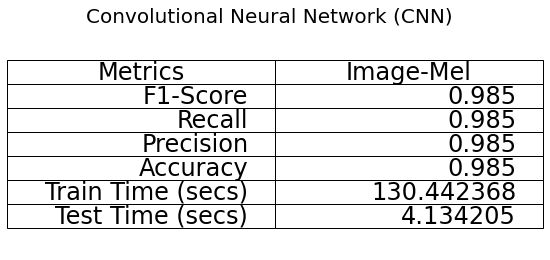

In [ ]:
metrics_mdc = [mdc_F1_Score, mdc_Recall, mdc_Precision, mdc_Accuracy, mdc_train_time, mdc_test_time]
fig = plt.figure()
ax = fig.add_subplot(111)
column_labels=["Metrics","1 Feature", "2 Features", "3 Features", "4 Features", "5 Features"]
ax.axis('tight')
ax.axis('off')
fig.suptitle('Minimum Distance Classifier (MDC)', fontsize=20)
the_table = ax.table(cellText=metrics_mdc, colWidths=[.4] * 6,colLabels=column_labels,loc="center")
the_table.auto_set_font_size(False)
the_table.set_fontsize(24)
the_table.scale(2, 2)
plt.show()


metrics_knn = [knn_F1_Score, knn_Recall,knn_Precision, knn_Accuracy, knn_train_time, knn_test_time]
fig = plt.figure()
ax = fig.add_subplot(111)
column_labels=["Metrics","1 Feature", "2 Features", "3 Features", "4 Features", "5 Features"]
ax.axis('tight')
ax.axis('off')
fig.suptitle('K-Nearest Neighbors Classifier (KNN)', fontsize=20)
the_table = ax.table(cellText=metrics_knn, colWidths=[.4] * 6,colLabels=column_labels,loc="center")
the_table.auto_set_font_size(False)
the_table.set_fontsize(24)
the_table.scale(2, 2)
plt.show()


metrics_ann = [ann_F1_Score, ann_Recall,ann_Precision, ann_Accuracy, ann_train_time, ann_test_time]
fig = plt.figure()
ax = fig.add_subplot(111)
column_labels=["Metrics","1 Feature", "2 Features", "3 Features", "4 Features", "5 Features"]
ax.axis('tight')
ax.axis('off')
fig.suptitle('Artificial Neural Network: Multi-Layer Perceptron (MLP)', fontsize=20)
the_table = ax.table(cellText=metrics_ann, colWidths=[.4] * 6,colLabels=column_labels,loc="center")
the_table.auto_set_font_size(False)
the_table.set_fontsize(24)
the_table.scale(2, 2)
plt.show()


metrics_cnn= [cnn_F1_Score, cnn_Recall, cnn_Precision, cnn_Accuracy, cnn_train_time, cnn_test_time]
fig = plt.figure()
ax = fig.add_subplot(111)
column_labels=["Metrics","Image-Mel"]
ax.axis('tight')
ax.axis('off')
fig.suptitle('Convolutional Neural Network (CNN)', fontsize=20)
the_table = ax.table(cellText=metrics_cnn, colWidths=[.4] * 2,colLabels=column_labels,loc="center")
the_table.auto_set_font_size(False)
the_table.set_fontsize(24)
the_table.scale(2, 2)
plt.show()

# Code showing the important features 

## KNN

In [ ]:
from sklearn.preprocessing import StandardScaler
#this part is explained in the conclusion
best_features = pd.concat([mfccs,contrast],axis=1)
scaler2 = StandardScaler()
scaler2.fit(best_features)
best_feature_data =scaler2.transform(best_features)
bX_tr, bX_t, bY_tr, bY_t = train_test_split(best_feature_data, labels, test_size=0.4, random_state=42)

In [ ]:
F1_Score = np.zeros(15) 
Recall = np.zeros(15) 
Precision = np.zeros(15) 
Accuracy= np.zeros(15) 
K = np.zeros(15) 

#run different K for each of the different lengths of features
for k in range(len(K)):
  K[k] = k+1
  model_knn = KNeighborsClassifier(n_neighbors=k+1,p=1)
  model_knn.fit(bX_tr,bY_tr)
  Y_testing_predicted=model_knn.predict(bX_t)
  F1_Score[k] = f1_score(bY_t,Y_testing_predicted,average='weighted')
  Recall[k] = recall_score(bY_t,Y_testing_predicted,average='weighted')
  Precision[k] = precision_score(bY_t,Y_testing_predicted,average='weighted')
  Accuracy[k] = accuracy_score(bY_t,Y_testing_predicted)

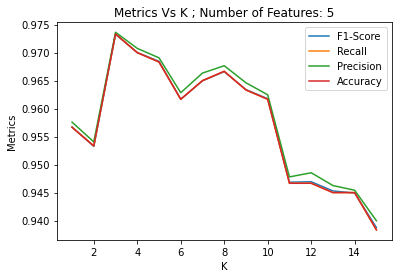

In [ ]:
plt.figure()
plt.plot(K, F1_Score, label="F1-Score")
plt.plot(K, Recall, label="Recall")
plt.plot(K, Precision, label="Precision")
plt.plot(K, Accuracy, label="Accuracy")
plt.xlabel("K")
plt.ylabel("Metrics")
plt.title('Metrics Vs K ; Number of Features: ' + str(i+1))
plt.legend()

In [ ]:
best_k = [np.argmax(Recall),np.argmax(F1_Score),np.argmax(Precision), np.argmax(Accuracy)]
print(best_k)

best_m = [np.max(Recall),np.max(F1_Score),np.max(Precision), np.max(Accuracy)]

print(best_m)
print(Precision[2])

[2, 2, 2, 2]
[0.9733333333333334, 0.9732808385459589, 0.973644355868267, 0.9733333333333334]
0.973644355868267


In [ ]:
model_knn = KNeighborsClassifier(n_neighbors=3+1, p=1)
model_knn.fit(bX_tr,bY_tr)
Y_testing_predicted=model_knn.predict(bX_t)
F1_Score= f1_score(bY_t,Y_testing_predicted,average='weighted')
Recall = recall_score(bY_t,Y_testing_predicted,average='weighted')
Precision = precision_score(bY_t,Y_testing_predicted,average='weighted')
Accuracy = accuracy_score(bY_t,Y_testing_predicted)
print('KNN result:')
print('Accuracy: ',accuracy_score(bY_t,Y_testing_predicted))
print('f1_score: ', f1_score(bY_t,Y_testing_predicted,average='weighted'))
print('Precision: ', precision_score(bY_t,Y_testing_predicted,average='weighted'))
print('Recall: ', recall_score(bY_t,Y_testing_predicted,average='weighted'))

KNN result:
Accuracy:  0.97
f1_score:  0.9700200079139072
Precision:  0.9707614523693383
Recall:  0.97


## MLP

In [ ]:
MLP = MLPClassifier(activation='relu',solver='adam',hidden_layer_sizes=(150,100,50),max_iter=5000,random_state=1)
MLP.fit(bX_tr, bY_tr)
MLP_Predicted=MLP.predict(bX_t)
print('MLP result:')
print('Accuracy: ',accuracy_score(bY_t,MLP_Predicted))
print('f1_score: ', f1_score(bY_t,MLP_Predicted,average='weighted'))
print('Precision: ', precision_score(bY_t,MLP_Predicted,average='weighted'))
print('Recall: ', recall_score(bY_t,MLP_Predicted,average='weighted'))

MLP result:
Accuracy:  0.945
f1_score:  0.9448884286721212
Precision:  0.9457981335892606
Recall:  0.945
